# Regression Analysis

Bu çalışmada HW_Dataset ve Linear Regression üzerine bir çalışma gerçekleştirildi. İlk önce veri seti keşfi ve analizi gerçekleştirildi. Daha sonra veri temizleme, görselleştirme ve regresyon algoritması uygulandı.

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 

from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
def correlation_df(data, remove_columns=None):
    if(remove_columns is None):
        corr = data.corr()
        corr = corr.where(np.triu(np.ones(corr.shape)).astype(np.bool))
        corr = corr.stack().reset_index()
        new_df = corr[corr["level_0"] != corr["level_1"]]
        new_df.columns = ['feature1','feature2','Corr']
        new_df["Corr"] = abs(new_df["Corr"])
    else:
        data2 = data.drop(remove_columns, axis=1)
        corr = data2.corr()
        corr = corr.where(np.triu(np.ones(corr.shape)).astype(np.bool))
        corr = corr.stack().reset_index()
        new_df = corr[corr["level_0"] != corr["level_1"]]
        new_df.columns = ['feature1','feature2','Corr']
        new_df["Corr"] = abs(new_df["Corr"])
    return new_df

In [3]:
def numeric_categoric_variable(data):
    name_of_col = list(data.columns)
    num_var_list = []
    str_var_list = []
    drop_col=[]

    str_var_list = name_of_col.copy()
    for var in name_of_col:
        # check if column belongs to numeric type
        if (data[var].dtypes not in (np.object, np.str)):
            str_var_list.remove(var)
            num_var_list.append(var)
        # drop the omit column from list
    for var in drop_col:
        if var in str_var_list:
            str_var_list.remove(var)
        if var in num_var_list:
            num_var_list.remove(var)
    print("Numeric Column  :\n", num_var_list,
          "\n\nCategoric Column :\n", str_var_list)
    return num_var_list, str_var_list

def layer1(data_norm, remove_col, threshold):
    corr_col=set()
    data2 = data.drop(remove_col, axis=1)
    corrmat=data2.corr()
    for i in range(len(corrmat.columns)):
        for j in range(i):
            if abs(corrmat.iloc[i,j] > threshold):
                colname=corrmat.columns[i]
                corr_col.add(colname)
    corr_col=list(corr_col)
    layer1_df = data_norm.drop(corr_col, axis=1)
    #layer1_df["labels"] = data_norm["labels"]
    return layer1_df

def layer2(new_df, target, num_feats):
    x = new_df.drop(target, axis=1)
    y = new_df[target]
    cor_list = []
    feature_name = list(x.columns)
    for i in list(x.columns):
        cor = np.corrcoef(x[i],y)[0,1]
        cor_list.append(cor)

    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    cor_feature = x.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    return cor_feature

In [4]:
data = pd.read_excel("HW_Data_Set.xlsx")
data.head()

,ind_5,ind_6,ind_8,ind_9,ind_10,ind_12,ind_13,ind_14,ind_15,ind_16,...,ind_416,ind_418,ind_420,ind_422,ind_424,ind_426,ind_428,20_target,50_target,90_target
0,19,17,100.0,85.714286,14.285714,72.363515,60.808814,23.80,17.62,11.73,...,-49.6,-54,-152,-353,1.0,0.498547,0.701906,15.135802,35.625252,36.997753
1,24,19,100.0,78.571429,21.428571,74.275883,64.366798,11.45,18.16,12.22,...,-55.6,-60,-158,-359,1.0,0.537088,0.690833,15.143348,35.643013,37.016198
2,30,24,100.0,71.428571,28.571429,75.140402,65.915803,8.75,17.86,12.28,...,-58.4,-60,-160,-362,1.0,0.615169,0.693040,15.146870,35.651301,-37.024805
3,37,30,100.0,64.285714,35.714286,76.677846,68.584234,7.80,14.76,12.61,...,-61.8,-65,-166,-367,1.0,0.661517,0.673418,15.153283,0.000000,-37.040483
4,41,37,100.0,57.142857,42.857143,81.603007,76.455495,14.90,11.92,14.25,...,-79.8,-86,-186,-388,1.0,0.747204,0.700522,-15.179065,-35.727079,-37.103503


Burada 20_target, 50_target ve 90_target olmak üzere 3 farklı hedef değişkenimiz bulunuyor. Burada 133 değişken üzerinde analiz yapıp, target verilerini ne kadar etkidiğini bulmaya çalışıyoruz.

# 1. Data Exploration

### 1.1. Veri Özetleme

In [5]:
data.shape

(6167, 136)

In [6]:
desc_df = data.describe().T
null_count = data.isnull().sum()
null_percent = (data.isnull().sum() / data.count())*100
variance = data.var()

desc_df["variance"] =  round(variance,3)
desc_df["null_values"] = round(null_count,3)
desc_df["null__rate"] = round(null_percent,3)
desc_df.T

,ind_5,ind_6,ind_8,ind_9,ind_10,ind_12,ind_13,ind_14,ind_15,ind_16,...,ind_412,ind_414,ind_416,ind_418,ind_424,ind_426,ind_428,20_target,50_target,90_target
count,6167.000000,6167.000000,6167.000000,6167.000000,6167.000000,6167.000000,6167.000000,6167.000000,6167.000000,6167.000000,...,6167.000000,6167.000000,6167.000000,6167.000000,6167.000000,6167.000000,6167.000000,6167.000000,6167.000000,6167.000000
mean,-0.803146,-0.803470,48.388890,48.289282,0.099609,49.488867,-18.497518,11.771485,11.773550,11.773392,...,0.000224,28.529204,-8.554792,-28.166694,0.490297,0.498188,0.490174,-0.057102,-2.906358,-3.315072
std,23.624403,23.624144,36.388526,36.478009,60.414625,12.198722,68.281120,6.803997,5.786089,4.970499,...,0.005660,26.316896,16.100087,23.271524,0.425376,0.228547,0.150483,14.834497,34.559778,36.841541
min,-131.000000,-131.000000,0.000000,0.000000,-100.000000,12.134540,-625.093855,1.050000,1.660000,2.580000,...,-0.023790,0.000000,-103.800000,-188.000000,0.000000,0.000000,0.083530,-15.780588,-37.142889,-38.573858
25%,-14.000000,-14.000000,14.285714,14.285714,-50.000000,40.868503,-45.687212,6.850000,7.260000,7.635000,...,-0.003230,10.700000,-11.700000,-39.000000,0.000000,0.323783,0.379894,-15.350354,-36.208094,-37.695273
50%,0.000000,0.000000,50.000000,50.000000,0.000000,49.549766,-2.817298,10.550000,11.040000,11.270000,...,-0.000053,21.300000,0.000000,-22.000000,0.473684,0.495192,0.487078,0.000000,-34.267756,-35.788391
75%,13.000000,13.000000,85.714286,85.714286,57.142857,58.504375,28.072613,14.950000,15.040000,14.960000,...,0.003414,38.400000,0.000000,-11.000000,1.000000,0.675730,0.601508,15.385945,35.879524,37.521892
max,76.000000,76.000000,100.000000,100.000000,100.000000,84.821848,81.105847,82.900000,54.240000,37.050000,...,0.023340,281.800000,0.000000,0.000000,1.000000,1.000000,0.868534,15.768767,37.038694,38.465649
variance,558.112000,558.100000,1324.125000,1330.645000,3649.927000,148.809000,4662.311000,46.294000,33.479000,24.706000,...,0.000000,692.579000,259.213000,541.564000,0.181000,0.052000,0.023000,220.062000,1194.378000,1357.299000
null_values,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### 1.2. Numerik ve Kategorik Öznitelikler

In [7]:
num, cat = numeric_categoric_variable(data)

Numeric Column  :
 ['ind_5', 'ind_6', 'ind_8', 'ind_9', 'ind_10', 'ind_12', 'ind_13', 'ind_14', 'ind_15', 'ind_16', 'ind_17', 'ind_18', 'ind_19', 'ind_20', 'ind_21', 'ind_22', 'ind_23', 'ind_25', 'ind_26', 'ind_27', 'ind_28', 'ind_29', 'ind_30', 'ind_31', 'ind_32', 'ind_33', 'ind_34', 'ind_35', 'ind_36', 'ind_37', 'ind_39', 'ind_40', 'ind_41', 'ind_42', 'ind_43', 'ind_44', 'ind_45', 'ind_46', 'ind_47', 'ind_48', 'ind_49', 'ind_50', 'ind_51', 'ind_52', 'ind_53', 'ind_56', 'ind_58', 'ind_61', 'ind_62', 'ind_65', 'ind_67', 'ind_70', 'ind_71', 'ind_74', 'ind_77', 'ind_82', 'ind_83', 'ind_88', 'ind_92', 'ind_102', 'ind_116', 'ind_118', 'ind_122', 'ind_124', 'ind_128', 'ind_130', 'ind_132', 'ind_134', 'ind_136', 'ind_139', 'ind_142', 'ind_145', 'ind_147', 'ind_150', 'ind_153', 'ind_156', 'ind_164', 'ind_168', 'ind_172', 'ind_176', 'ind_179', 'ind_181', 'ind_188', 'ind_194', 'ind_212', 'ind_217', 'ind_225', 'ind_228', 'ind_234', 'ind_237', 'ind_239', 'ind_241', 'ind_243', 'ind_309', 'ind_310'

Kategorik verilerde kaç farklı kategori mevcut olduğunu kontrol ediyoruz. ind_420 ve ind_422 özniteliklerde sırasıyla 582 ve 573 olmak üzere farklı kategori mevcut olduğu çıkıyor. Bu nedenle group by ile değerleri kontrol ettiğimizde tüm değerlerin numerik olduğunu ve "?" olarak girilen 1041 satır kirli veri olduğunu görüyoruz. Veri Temizleme işlemi uygulamamız gerekiyor.

In [8]:
for i in data.select_dtypes(include=["object"]).columns:
    print(i,": ",data[i].value_counts().count())

ind_109 :  2
ind_420 :  582
ind_422 :  573


In [9]:
data.groupby("ind_420").count().tail(5)

,ind_5,ind_6,ind_8,ind_9,ind_10,ind_12,ind_13,ind_14,ind_15,ind_16,...,ind_414,ind_416,ind_418,ind_422,ind_424,ind_426,ind_428,20_target,50_target,90_target
ind_420,,,,,,,,,,,,,,,,,,,,,
288,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
290,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
291,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
297,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
?,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041,...,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041


In [10]:
data.groupby("ind_422").count().tail(5)

,ind_5,ind_6,ind_8,ind_9,ind_10,ind_12,ind_13,ind_14,ind_15,ind_16,...,ind_414,ind_416,ind_418,ind_420,ind_424,ind_426,ind_428,20_target,50_target,90_target
ind_422,,,,,,,,,,,,,,,,,,,,,
117,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
118,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
119,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
124,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
?,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041,...,1041,1041,1041,1041,1041,1041,1041,1041,1041,1041


# 2. Data Preprocessing

### 2.1. Veri Temizleme (Replace with NULL)

Burada ind_420 ve ind_422 özniteliklerinde "?" değerlerini NULL değerler ile değiştiriyoruz. Böylece bu iki öznitelik numerik değerlere dönüşüyor

In [11]:
data["ind_420"] = data["ind_420"].replace("?", np.nan)
data["ind_422"] = data["ind_422"].replace("?", np.nan)

### 2.2. Veri Temizleme (Drop columns)

Burada "?" değerleri içeren ind_420 ve ind_422 özniteliklerini verisetimizden siliyoruz.

In [12]:
data = data.drop(["ind_420", "ind_422"], axis=1)
data.head()

,ind_5,ind_6,ind_8,ind_9,ind_10,ind_12,ind_13,ind_14,ind_15,ind_16,...,ind_412,ind_414,ind_416,ind_418,ind_424,ind_426,ind_428,20_target,50_target,90_target
0,19,17,100.0,85.714286,14.285714,72.363515,60.808814,23.80,17.62,11.73,...,0.002371,2.0,-49.6,-54,1.0,0.498547,0.701906,15.135802,35.625252,36.997753
1,24,19,100.0,78.571429,21.428571,74.275883,64.366798,11.45,18.16,12.22,...,0.003074,0.8,-55.6,-60,1.0,0.537088,0.690833,15.143348,35.643013,37.016198
2,30,24,100.0,71.428571,28.571429,75.140402,65.915803,8.75,17.86,12.28,...,0.003561,2.7,-58.4,-60,1.0,0.615169,0.693040,15.146870,35.651301,-37.024805
3,37,30,100.0,64.285714,35.714286,76.677846,68.584234,7.80,14.76,12.61,...,0.004366,0.9,-61.8,-65,1.0,0.661517,0.673418,15.153283,0.000000,-37.040483
4,41,37,100.0,57.142857,42.857143,81.603007,76.455495,14.90,11.92,14.25,...,0.004198,0.1,-79.8,-86,1.0,0.747204,0.700522,-15.179065,-35.727079,-37.103503


### 2.3. Data Transformation
#### 2.3.1. Label Encoder Donusumu

ind_109 değişkeni kategorik değişkenlerdir. GREEN ve RED değerleri aldığı için hedef değişkeni tahmin etmede önemli olacağını düşünerek dönüştürme işlemi uyguladım.

In [13]:
'''from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

le.fit(data["ind_109"])
data["ind_109"] = le.fit_transform(data["ind_109"])

np.unique(data["ind_109"])
'''

'from sklearn.preprocessing import LabelEncoder\nle = LabelEncoder()\n\nle.fit(data["ind_109"])\ndata["ind_109"] = le.fit_transform(data["ind_109"])\n\nnp.unique(data["ind_109"])\n'

#### 2.3.2. Dummy Dönüştürme 

ind_109 değişkeni kategorik değişkenlerdir. GREEN ve RED değerleri aldığı için hedef değişkeni tahmin etmede önemli olacağını düşünerek dönüştürme işlemi uyguladım.

In [14]:
dummy = pd.get_dummies(data["ind_109"])
data_dummy = pd.concat([data, dummy],axis=1)
data_dummy = data_dummy.drop(["ind_109"], axis=1)
data_dummy.head()
data = data_dummy

Dummy donusumu sonrasinda uygulayacagimiz model icin hicbir kategorik degiskenimizin olmadigini test ediyoruz

In [15]:
num, cat = numeric_categoric_variable(data)

Numeric Column  :
 ['ind_5', 'ind_6', 'ind_8', 'ind_9', 'ind_10', 'ind_12', 'ind_13', 'ind_14', 'ind_15', 'ind_16', 'ind_17', 'ind_18', 'ind_19', 'ind_20', 'ind_21', 'ind_22', 'ind_23', 'ind_25', 'ind_26', 'ind_27', 'ind_28', 'ind_29', 'ind_30', 'ind_31', 'ind_32', 'ind_33', 'ind_34', 'ind_35', 'ind_36', 'ind_37', 'ind_39', 'ind_40', 'ind_41', 'ind_42', 'ind_43', 'ind_44', 'ind_45', 'ind_46', 'ind_47', 'ind_48', 'ind_49', 'ind_50', 'ind_51', 'ind_52', 'ind_53', 'ind_56', 'ind_58', 'ind_61', 'ind_62', 'ind_65', 'ind_67', 'ind_70', 'ind_71', 'ind_74', 'ind_77', 'ind_82', 'ind_83', 'ind_88', 'ind_92', 'ind_102', 'ind_116', 'ind_118', 'ind_122', 'ind_124', 'ind_128', 'ind_130', 'ind_132', 'ind_134', 'ind_136', 'ind_139', 'ind_142', 'ind_145', 'ind_147', 'ind_150', 'ind_153', 'ind_156', 'ind_164', 'ind_168', 'ind_172', 'ind_176', 'ind_179', 'ind_181', 'ind_188', 'ind_194', 'ind_212', 'ind_217', 'ind_225', 'ind_228', 'ind_234', 'ind_237', 'ind_239', 'ind_241', 'ind_243', 'ind_309', 'ind_310'

# 3. Feature Selection (Correlation)

In [16]:
print(correlation_df(data, ["20_target","50_target","90_target"]).sort_values(by="Corr", ascending=False).head(5),"\n")
print(correlation_df(data, ["20_target","50_target","90_target"]).sort_values(by="Corr", ascending=True).head(5))

     feature1 feature2      Corr
8776    GREEN      RED  1.000000
8674  ind_403  ind_404  1.000000
7699  ind_225  ind_234  0.999907
6082  ind_102  ind_128  0.999641
8184  ind_316  ind_318  0.998663 

     feature1 feature2      Corr
8060  ind_310  ind_399  0.000009
2418   ind_27  ind_321  0.000044
3638   ind_40   ind_51  0.000055
8572  ind_351  ind_397  0.000056
8537  ind_347  ind_410  0.000095


In [17]:
fs_df = layer1(data ,["20_target","50_target","90_target"], 0.6)
fs_df.head()

,ind_5,ind_8,ind_9,ind_14,ind_18,ind_26,ind_27,ind_28,ind_40,ind_42,...,ind_338,ind_340,ind_344,ind_347,ind_349,ind_351,ind_416,20_target,50_target,90_target
0,19,100.0,85.714286,23.80,9.1100,-0.002670,0.000010,66.666667,3,-5,...,1.197238,-0.319064,0.0,0.0,0.0,0.0,-49.6,15.135802,35.625252,36.997753
1,24,100.0,78.571429,11.45,9.2225,-0.003111,-0.000191,66.666667,3,-6,...,1.197328,-0.318905,0.0,0.0,0.0,0.0,-55.6,15.143348,35.643013,37.016198
2,30,100.0,71.428571,8.75,9.3125,-0.003530,-0.000375,66.666667,3,-4,...,1.197419,-0.318831,0.0,0.0,0.0,0.0,-58.4,15.146870,35.651301,-37.024805
3,37,100.0,64.285714,7.80,9.4150,-0.003961,-0.000641,66.666667,3,-5,...,1.197509,-0.318696,0.0,0.0,0.0,0.0,-61.8,15.153283,0.000000,-37.040483
4,41,100.0,57.142857,14.90,9.8925,-0.004624,-0.000319,66.666667,2,-18,...,1.197600,-0.318155,0.0,0.0,0.0,0.0,-79.8,-15.179065,-35.727079,-37.103503


In [18]:
gg = fs_df.drop(["50_target","90_target"],axis=1)
fs_df = fs_df[layer2(gg,  "20_target", 10)]
fs_df["20_target"] = data["20_target"]
fs_df.head()

,ind_27,ind_18,ind_239,ind_316,ind_324,ind_330,ind_5,ind_338,ind_334,ind_332,20_target
0,0.000010,9.1100,0.000217,98.905563,-0.000062,-0.157039,19,1.197238,-0.000091,20.967742,15.135802
1,-0.000191,9.2225,0.000217,98.859627,-0.000062,-0.156961,24,1.197328,-0.000091,20.800000,15.143348
2,-0.000375,9.3125,0.000217,98.839991,-0.000062,-0.156925,30,1.197419,-0.000091,20.634921,15.146870
3,-0.000641,9.4150,0.000217,98.801500,-0.000062,-0.156858,37,1.197509,-0.000091,20.472441,15.153283
4,-0.000319,9.8925,0.000217,98.637028,-0.000062,-0.156592,41,1.197600,-0.000091,20.312500,-15.179065


In [19]:
import pylab
import scipy.stats as stats
num, cat = numeric_categoric_variable(fs_df)

Numeric Column  :
 ['ind_27', 'ind_18', 'ind_239', 'ind_316', 'ind_324', 'ind_330', 'ind_5', 'ind_338', 'ind_334', 'ind_332', '20_target'] 

Categoric Column :
 []


# 4. Visualization

### 4.1. Heat Map

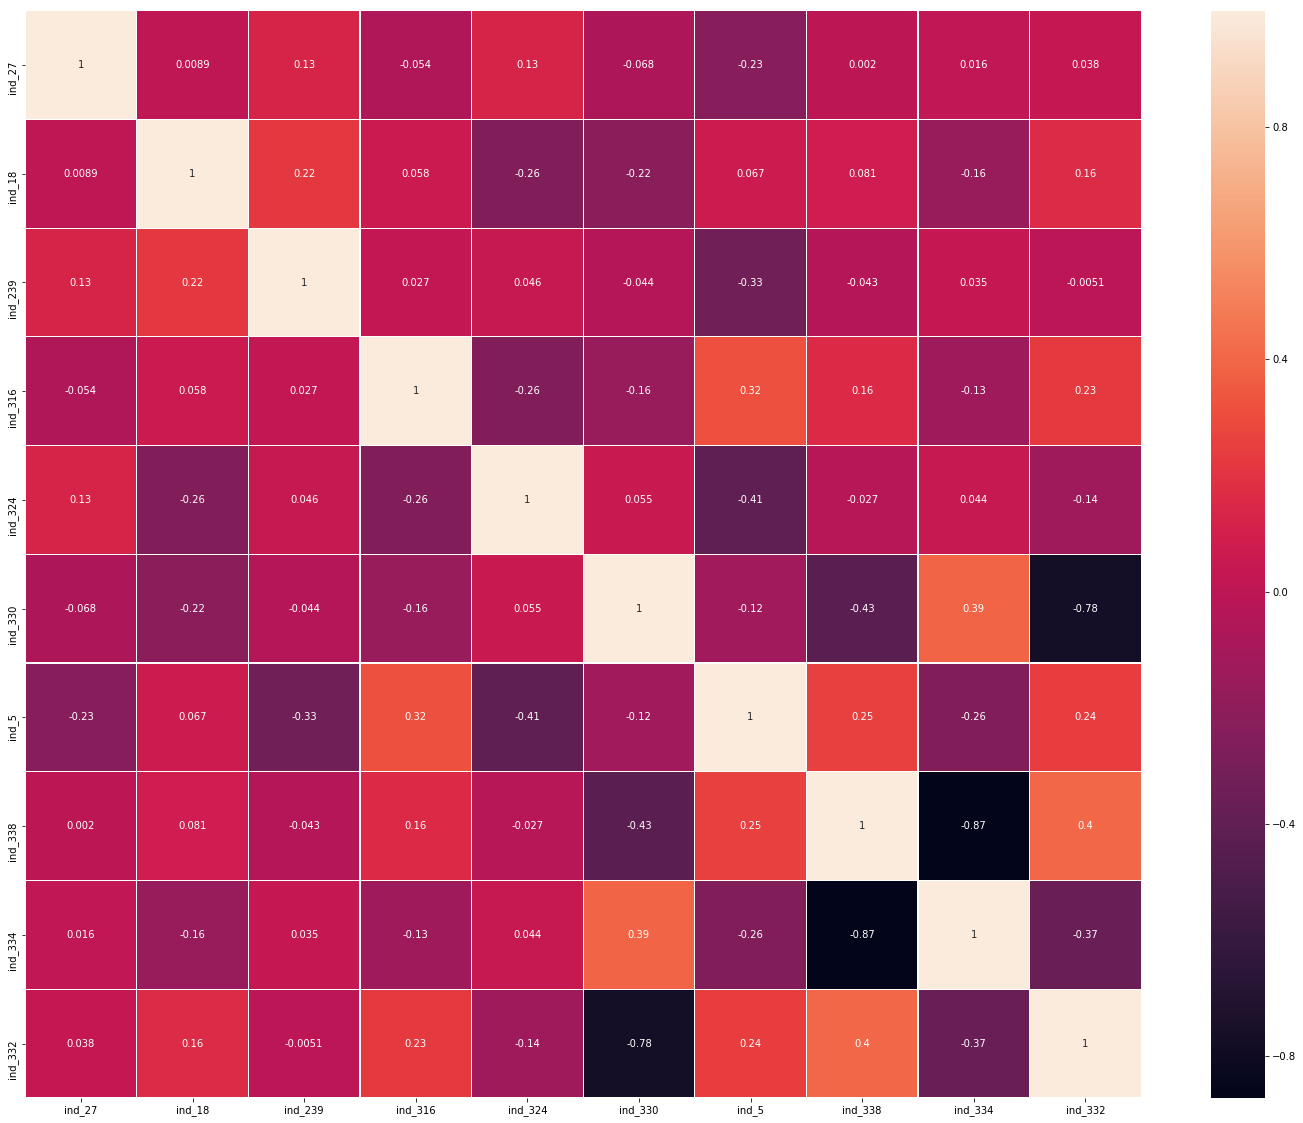

In [20]:
fig, ax = plt.subplots(figsize=(25,20))  
corrmat = fs_df.drop(["20_target"], axis=1)
sns.heatmap(corrmat.corr(), annot=True, linewidths=0.2, ax=ax)
plt.show()

In [21]:
print(correlation_df(fs_df, ["20_target"]).sort_values(by="Corr", ascending=False).head(5),"\n")
print(correlation_df(fs_df, ["20_target"]).sort_values(by="Corr", ascending=True).head(5))

   feature1 feature2      Corr
50  ind_338  ind_334  0.871267
44  ind_330  ind_332  0.775937
42  ind_330  ind_338  0.427342
36  ind_324    ind_5  0.409430
51  ind_338  ind_332  0.404481 

   feature1 feature2      Corr
7    ind_27  ind_338  0.002009
26  ind_239  ind_332  0.005120
1    ind_27   ind_18  0.008946
8    ind_27  ind_334  0.015735
37  ind_324  ind_338  0.027333


### 4.2. Box Plot (Outlier ve 5 Five Number Summary)

Verilerimizde cok sayida Outlier deger oldugunu boxplot grafigi ile goruyoruz. Burada iki yaklasim uygulanabilir. 

1. Outlier degerler silinebilir 
2. Veriler normalize edilebilir

Burada orjinal veriler oldugunu dusunerek outlier degerleri remove etmeyip normalize yontemini seciyoruz. Normalize yöntemi olarak StandardScaler, Z-Score, Min-Max uygulayabiliriz.

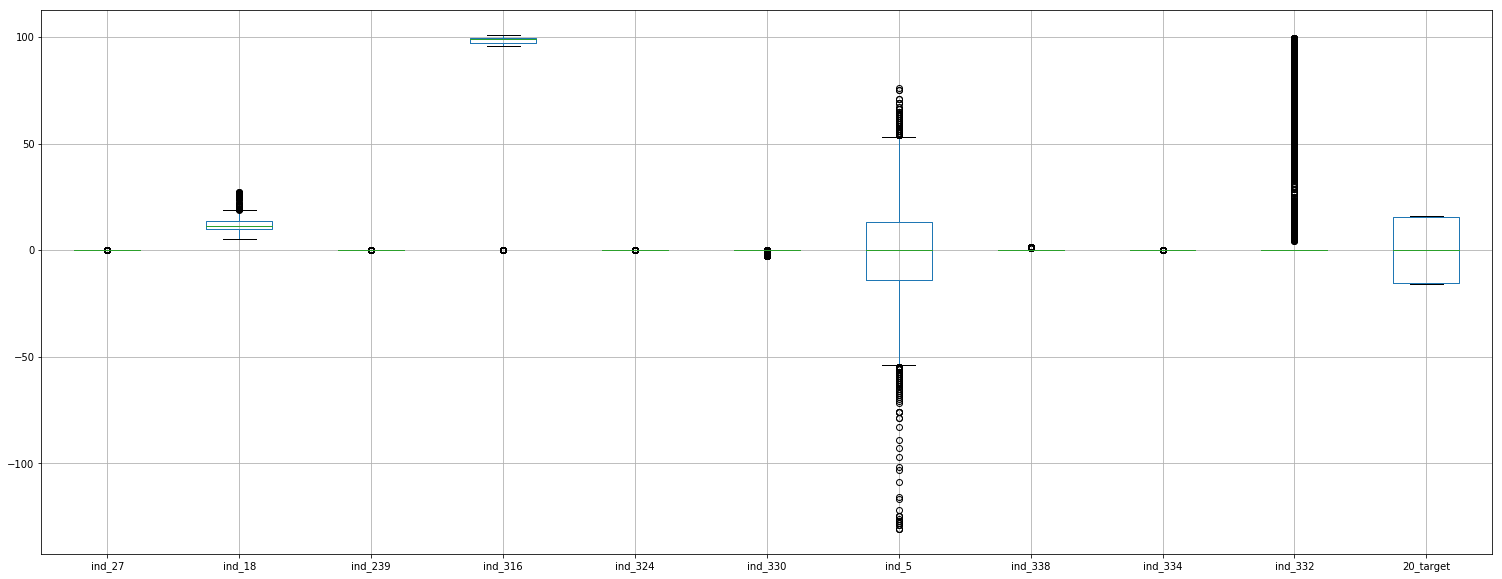

In [22]:
plt.figure(figsize=(26,10))
fs_df.boxplot()
plt.show()

### 4.3. Histogam (Dagilim Grafigi)

Burada ozniteliklerin cogunun normal dagilimdan gelmedigini goruyoruz. Bu nedenle normal dagildigini dusundugumuz oznitelikler icin shapiro normalllik testi uygulamamiz gerekiyor. 

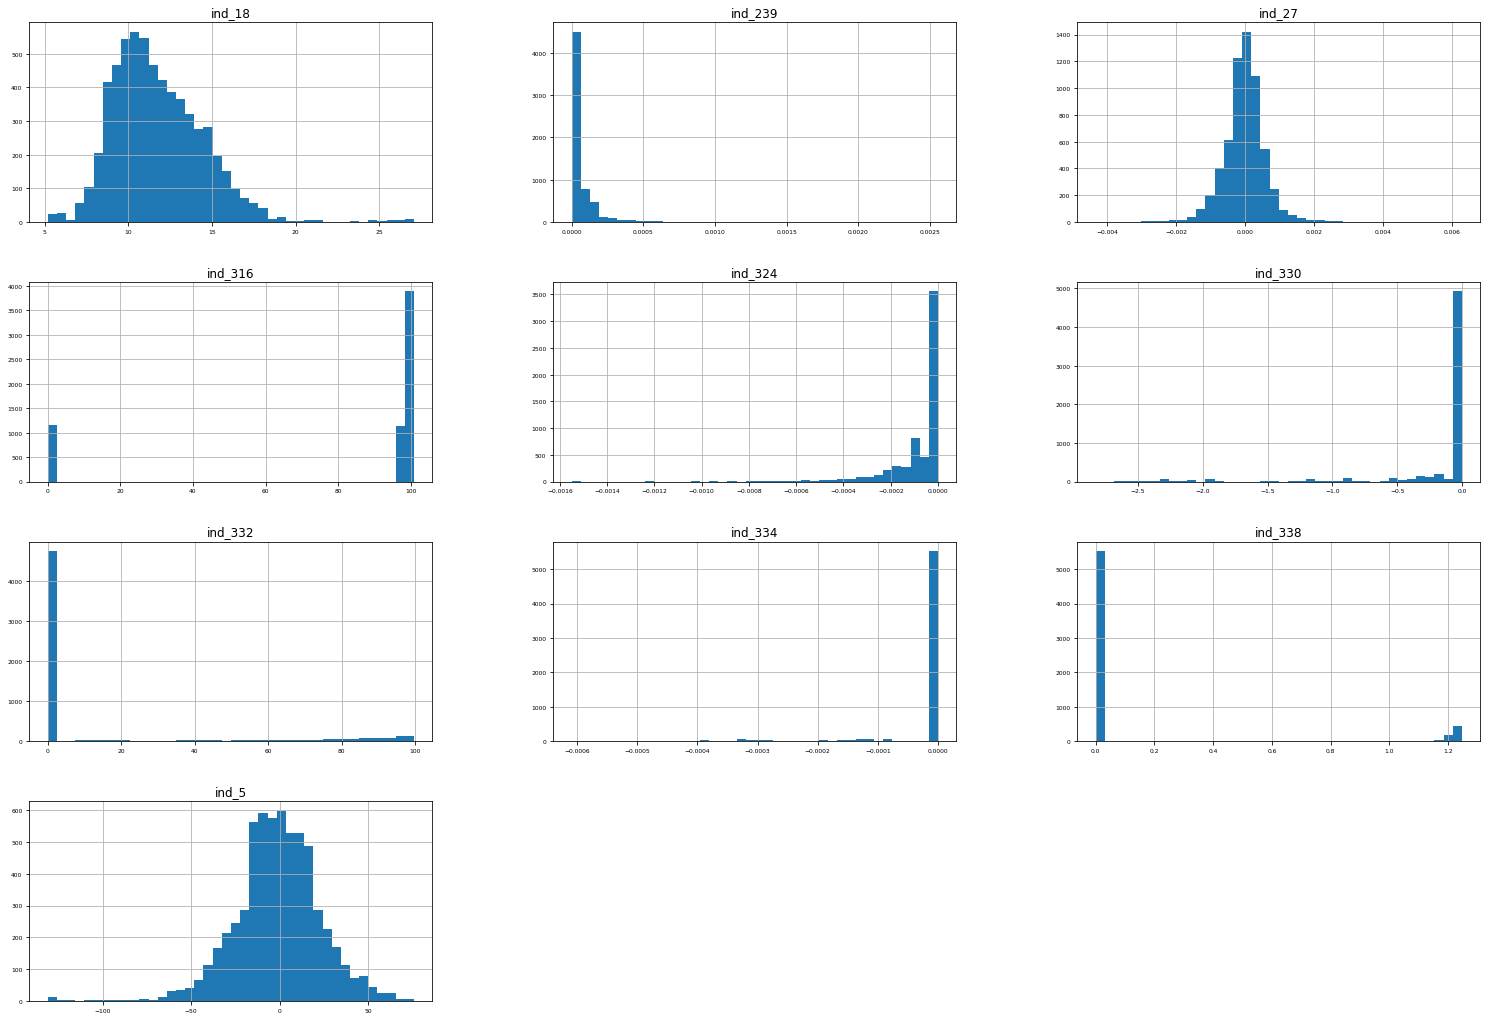

In [23]:
data_df = fs_df.drop(["20_target"], axis=1)
data_df.hist(figsize=(26,18), bins=40, xlabelsize=6, ylabelsize=6)
plt.show()

# 5. Normalization

Veriler uzerinde outlier degerlerin oldugunu gorduk ve boylece Min-Max Normalizasyon yontemi uyguladik

In [24]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(fs_df)
dd = scaler.transform(fs_df)
fs_df = pd.DataFrame(dd, columns=fs_df.columns)
fs_df.head()

,ind_27,ind_18,ind_239,ind_316,ind_324,ind_330,ind_5,ind_338,ind_334,ind_332,20_target
0,0.409832,0.179402,0.084932,0.979995,0.960129,0.944473,0.724638,0.960087,0.851232,0.210376,0.979937
1,0.390871,0.184535,0.084932,0.979540,0.960129,0.944500,0.748792,0.960159,0.851232,0.208693,0.980177
2,0.373539,0.188641,0.084932,0.979346,0.960129,0.944513,0.777778,0.960232,0.851232,0.207037,0.980288
3,0.348484,0.193317,0.084932,0.978964,0.960129,0.944537,0.811594,0.960305,0.851232,0.205407,0.980491
4,0.378814,0.215100,0.084932,0.977335,0.960129,0.944631,0.830918,0.960377,0.851232,0.203802,0.019066


### 5.1. Distribution Plot

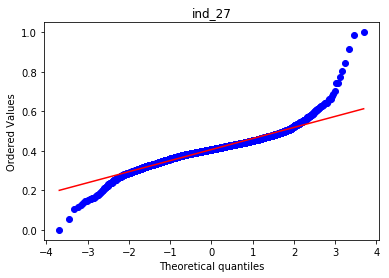

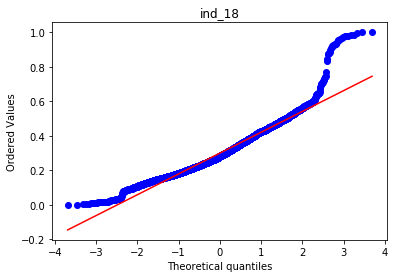

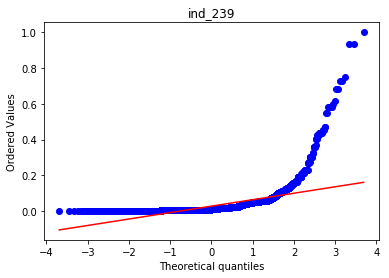

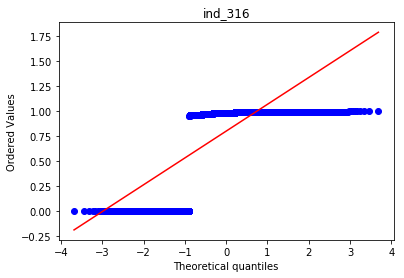

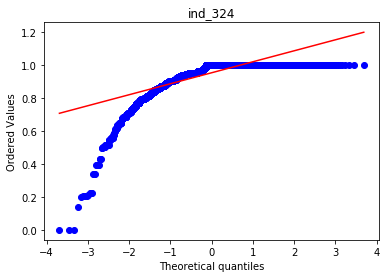

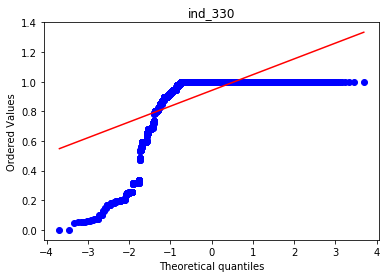

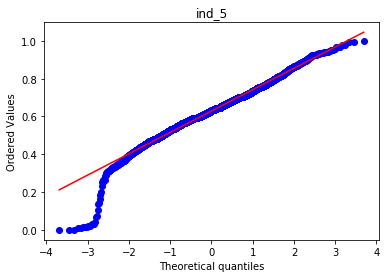

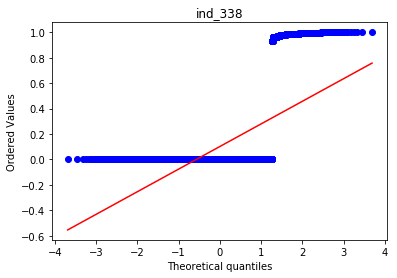

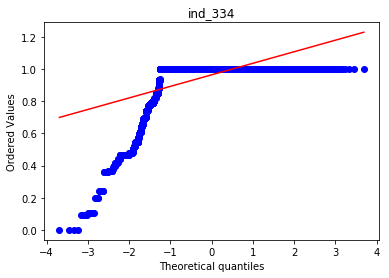

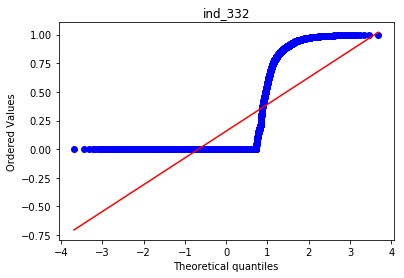

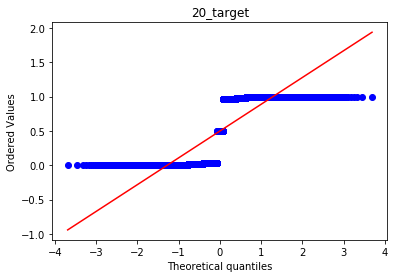

In [25]:
for i in num:
    stats.probplot(fs_df[i], dist="norm", plot=plt)
    plt.title(i)
    plt.show()

# 6. Multiple Linear Regression

In [26]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict

df = fs_df.copy()
x_df = df.drop(["20_target"], axis=1)
y_df  = df["20_target"]

x_train, x_test, y_train, y_test = train_test_split(x_df,y_df, test_size=0.2, random_state=42)

In [27]:
x_train.shape, y_train.shape, x_test.shape, x_test.shape

((4933, 10), (4933,), (1234, 10), (1234, 10))

In [28]:
lm = sm.OLS(y_train, np.asarray(x_train))
model = lm.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              20_target   R-squared:                       0.530
Model:                            OLS   Adj. R-squared:                  0.529
Method:                 Least Squares   F-statistic:                     555.4
Date:                Sun, 23 Aug 2020   Prob (F-statistic):               0.00
Time:                        13:23:06   Log-Likelihood:                -3250.5
No. Observations:                4933   AIC:                             6521.
Df Residuals:                    4923   BIC:                             6586.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0818      0.114     -0.715      0.475      -0.306       0.143
x2             0.1515      0.056      2.720      0.007       0.042       0.261
x3            -0.2512      0.134     -1.880      0.060      -0.513       0.011
x4             0.0365      0.019      1.924      0.054      -0.001       0.074
x5             0.0951      0.071      1.331      0.183      -0.045       0.235
x6             0.2615      0.062      4.221      0.000       0.140       0.383
x7             0.0793      0.067      1.186      0.236      -0.052       0.210
x8             0.0597      0.040      1.480      0.139      -0.019       0.139
x9             0.0340      0.086      0.393      0.694      -0.135       0.203
x10            0.2150      0.034      6.322      0.000       0.148       0.282
==============================================================================
Omnibus:                        0.417   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.812   Jarque-Bera (JB):              726.810
Skew:                           0.022   Prob(JB):                    1.50e-158
Kurtosis:                       1.120   Cond. No.                         41.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 6.1. Elimination 1

In [29]:
x_train = x_train.drop(["ind_316"], axis=1)
lm = sm.OLS(y_train, np.asarray(x_train))
model = lm.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              20_target   R-squared:                       0.530
Model:                            OLS   Adj. R-squared:                  0.529
Method:                 Least Squares   F-statistic:                     616.4
Date:                Sun, 23 Aug 2020   Prob (F-statistic):               0.00
Time:                        13:23:06   Log-Likelihood:                -3252.3
No. Observations:                4933   AIC:                             6523.
Df Residuals:                    4924   BIC:                             6581.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0779      0.114     -0.681      0.496      -0.302       0.146
x2             0.1484      0.056      2.664      0.008       0.039       0.258
x3            -0.2128      0.132     -1.610      0.107      -0.472       0.046
x4             0.0768      0.071      1.084      0.278      -0.062       0.216
x5             0.2648      0.062      4.275      0.000       0.143       0.386
x6             0.1171      0.064      1.832      0.067      -0.008       0.242
x7             0.0675      0.040      1.682      0.093      -0.011       0.146
x8             0.0506      0.086      0.588      0.556      -0.118       0.219
x9             0.2219      0.034      6.561      0.000       0.156       0.288
==============================================================================
Omnibus:                        0.465   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.793   Jarque-Bera (JB):              728.620
Skew:                           0.024   Prob(JB):                    6.06e-159
Kurtosis:                       1.118   Cond. No.                         37.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 6.2.  Elimination 2

In [30]:
x_train = x_train.drop(["ind_5"], axis=1)
lm = sm.OLS(y_train, np.asarray(x_train))
model = lm.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              20_target   R-squared:                       0.529
Model:                            OLS   Adj. R-squared:                  0.529
Method:                 Least Squares   F-statistic:                     692.7
Date:                Sun, 23 Aug 2020   Prob (F-statistic):               0.00
Time:                        13:23:06   Log-Likelihood:                -3254.0
No. Observations:                4933   AIC:                             6524.
Df Residuals:                    4925   BIC:                             6576.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0917      0.114     -0.803      0.422      -0.316       0.132
x2             0.1703      0.054      3.131      0.002       0.064       0.277
x3            -0.2896      0.125     -2.310      0.021      -0.535      -0.044
x4             0.0598      0.070      0.851      0.395      -0.078       0.198
x5             0.3030      0.058      5.196      0.000       0.189       0.417
x6             0.0956      0.037      2.578      0.010       0.023       0.168
x7             0.1010      0.082      1.239      0.216      -0.059       0.261
x8             0.2427      0.032      7.614      0.000       0.180       0.305
==============================================================================
Omnibus:                        0.483   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.785   Jarque-Bera (JB):              727.493
Skew:                           0.024   Prob(JB):                    1.06e-158
Kurtosis:                       1.119   Cond. No.                         33.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# 7. Evaluation

Burada modelimizdeki hatalar standard dagilima gore nasil bir dagilim gosterdigini hesapliyoruz. Hatamizin standard dagilimdan gelmesi gerekiyor. Grafikte goruldugu gibi hatalarimiz uclarda oldugundan outlier gozlemler bulunuyor. Yani modelimiz dogru bir fit yapmamis.

Leverage v.s. Studentized Residuals


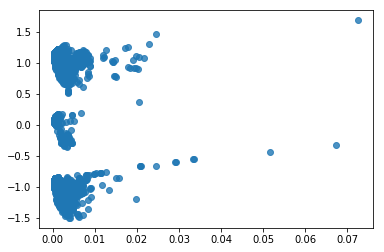

In [31]:
influence = model.get_influence()
resid_student = influence.resid_studentized_external
(cooks, p) = influence.cooks_distance
(dffits, p) = influence.dffits
leverage = influence.hat_matrix_diag
print("Leverage v.s. Studentized Residuals")
sns.regplot(leverage, model.resid_pearson, fit_reg=False)

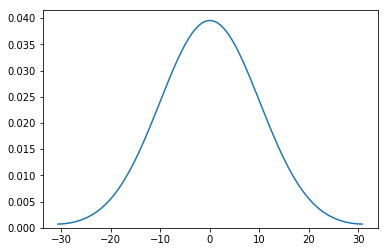

In [32]:
hw_df = pd.concat([x_train , pd.Series(model.resid, name = 'resid'), pd.Series(model.predict(), name = "predict")], axis = 1)
sns.kdeplot(np.array(hw_df.resid), bw=10)
plt.show()

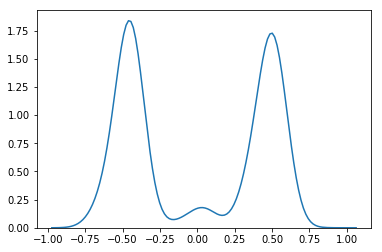

In [33]:
sns.distplot(np.array(hw_df.resid), hist=False)
plt.show()

### 7.1. Hatalarin Dagilimi 

Burda goruyoruz ki hatalarimiz bekledigimiz normal dagilim varsayimina uymamaktadir. 

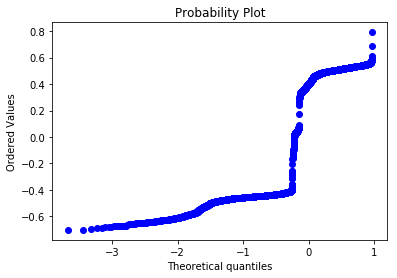

In [34]:
import pylab
stats.probplot(hw_df.resid, dist="norm", plot=pylab)
pylab.show()

In [35]:
from scipy.stats import shapiro

stat, p =shapiro(hw_df.resid)
alpha = 0.05
if p > alpha:
    print('Hatalar Normal (Gaussian) Dağılımdan gelmektedir (Fail to Reject H0)')
else:
    print('Hatalar Normal (Gaussian) Dağılımdan gelmemektedir (reject H0)')

Hatalar Normal (Gaussian) Dağılımdan gelmektedir (Fail to Reject H0)


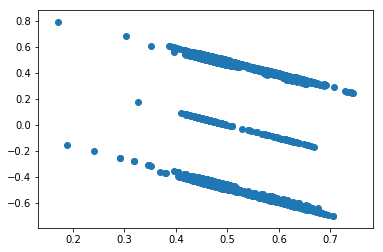

In [37]:
resid = model.resid
plt.scatter(model.predict(), resid)

In [38]:
from sklearn.metrics import mean_squared_error, r2_score
print("Train MSE: ",np.sqrt(mean_squared_error(y_train, model.predict(x_train))))
print("Test MSE: ",np.sqrt(mean_squared_error(y_test, model.predict(x_test[x_train.columns]))))


Train MSE:  0.46799698539497386
Test MSE:  0.46751862739942407
